In [1]:
import sys, os
import numpy as np
sys.path.append('./overlap-code')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, datasets
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_recall_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from overrule.overrule import OverRule2Stage, OverRule
from overrule.baselines import knn, marginal, propscore, svm
from overrule.support import SVMSupportEstimator, SupportEstimator
from overrule.overlap import SupportOverlapEstimator
from overrule.ruleset import BCSRulesetEstimator, RulesetEstimator

from utils import get_data, rule_str

In [2]:
SEED=0

CNF=False
VERBOSE=True

ALPHA_s=0.99
N_REF_MULT_s=0.3
ALPHA_o=0.90
N_REF_MULT_o=0

LAMBDA0_s=0.1 # | 1e-05 fixed cost of term, the smaller the more rules you'll allow 
LAMBDA1_s=0.001 # cost per literal

LAMBDA0_o=0.0000001 # fixed cost of term, the smaller the more rules you'll allow 
LAMBDA1_o=0.0000001 # cost per literal

D=10  # Maximum extra rules per beam seach iteration
K=10  # Maximum results returned during beam search
B=28  # Width of Beam Search

np.random.seed(SEED)
w_eps = 1e-8
CAT_COLS = []


In [3]:
data = pd.read_csv('data/fp_pca.csv')
X_df, a, y = get_data(data, data.columns[:-2])
# X_df = X_df[X_df['v312_3'] == 1]

In [4]:
base_estimator = LogisticRegression(
    penalty="l2", 
    max_iter=2000,
    class_weight="balanced",
    random_state=2,
    solver='lbfgs'
)
learner = CalibratedClassifierCV(base_estimator=base_estimator, cv=5, method='sigmoid')
param_grid = {'base_estimator__C': np.logspace(-5, 0, 20)}
search = GridSearchCV(learner, param_grid, cv=5, scoring='roc_auc')

model = make_pipeline(StandardScaler(), search)
model.fit(X_df, a)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True...e_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0))])

In [5]:
clrmodel = make_pipeline(StandardScaler(), model.steps[1][1].best_estimator_) 
clrmodel.fit(X_df, a)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('calibratedclassifiercv', CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.002335721469090121, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=2000, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=2, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False),
            cv=5, method='sigmoid'))])

In [6]:
a_pred = clrmodel.predict_proba(X_df)[:,1]
roc_auc_score(a, a_pred, sample_weight=None)

0.8104565684551241

In [7]:
def OverruleFit(model, X_df_sample, a_sample, LAMBDA0_s, LAMBDA1_s):

    f_cols = X_df_sample.columns
    O = propscore.PropensityOverlapEstimator(estimator=model)

    RS_s = BCSRulesetEstimator(n_ref_multiplier=N_REF_MULT_s, alpha=ALPHA_s, lambda0=LAMBDA0_s, lambda1=LAMBDA1_s, B=B, CNF=CNF, 
                               cat_cols=CAT_COLS, seed=SEED, K=K, D=D, binarizer='tree')
    RS_o = BCSRulesetEstimator(n_ref_multiplier=N_REF_MULT_o, alpha=ALPHA_o, lambda0=LAMBDA0_o, lambda1=LAMBDA1_o, B=B, CNF=CNF, 
                               cat_cols=CAT_COLS, seed=SEED, binarizer='tree')

    RS_s.fit(X_df_sample, a_sample)
    M = OverRule2Stage(O, RS_o, RS_s, refit_s=False)
    M.fit(X_df_sample, a_sample)
    
    TPR = RS_s.predict(X_df_sample).mean()
    FPR = RS_s.relative_volume
    auc = 1/2 -  (FPR)/2 + TPR/2
    score_base = M.score_vs_base(X_df_sample)
    
    return M, RS_s, RS_o, auc, score_base

In [8]:
M_clr, RS_s_clr, RS_o_clr, auc_clr, score_base_clr = OverruleFit(clrmodel, X_df, a, LAMBDA0_s, LAMBDA1_s)

(302221, 28)
(5168, 30)


In [9]:
rules_clr = M_clr.rules(as_str=False)
print(auc_clr)
print(score_base_clr)

0.7921542535605298
0.8696282992977642


In [10]:
print(RS_o_clr.complexity())
print(RS_s_clr.complexity())

(6, 30)
(2, 7)


In [11]:
ALPHA_s, LAMBDA0_s, LAMBDA1_s, LAMBDA0_o, LAMBDA1_o

(0.99, 0.1, 0.001, 1e-07, 1e-07)

In [12]:
base_estimator = KNeighborsClassifier()

learner = CalibratedClassifierCV(base_estimator=base_estimator, cv=5, method='sigmoid')
param_grid = {'base_estimator__n_neighbors': list(np.arange(30, 32, 2)), 'base_estimator__metric': ['minkowski']}
search = GridSearchCV(learner, param_grid, cv=5, scoring='roc_auc')

model = make_pipeline(StandardScaler(), search)
model.fit(X_df, a)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_...e_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0))])

In [13]:
knnmodel = make_pipeline(StandardScaler(), model.steps[1][1].best_estimator_) 
knnmodel.fit(X_df, a)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('calibratedclassifiercv', CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform'),
            cv=5, method='sigmoid'))])

In [14]:
M_knn, RS_s_knn, RS_o_knn, auc_knn, score_base_knn = OverruleFit(knnmodel, X_df, a, LAMBDA0_s, LAMBDA1_s)

(302221, 28)
(5168, 36)


In [15]:
rules_knn = M_knn.rules(as_str=False)
print(auc_knn)
print(score_base_knn)

0.7921542535605298
0.8879001823121724


In [19]:
print(RS_o_knn.complexity())
print(RS_s_knn.complexity())

(6, 20)
(2, 7)


In [20]:
model = 'clr'
rules = rules_clr
RS_s = RS_s_clr
RS_o = RS_o_clr
auc = auc_clr
score_base  = score_base_clr

In [28]:
import time
outfile = open('results.txt', 'a+')


outfile.write('Time: {}\n'.format(time.time()))
outfile.write('Binarizer: {}, {}\n'.format(RS_s.binarizer, RS_o.binarizer))
outfile.write('Params (knn): N_REF_MULT_s {}, N_REF_MULT_o {}, ALPHA_s {}, ALPHA_o {}, LAMBDA0_s {}, \
                LAMBDA1_s {}, LAMBDA0_o {}, LAMBDA1_o {}, B {}, CNF {}\n\n'.
                    format(N_REF_MULT_s, N_REF_MULT_o, ALPHA_s, ALPHA_o, LAMBDA0_s, LAMBDA1_s, LAMBDA0_o, LAMBDA1_o, B, CNF))

outfile.write('Number of reference samples: {}\n'.format(RS_s.refSamples.shape[0]))
outfile.write('Complexity: {}\n'.format(RS_s.complexity()))
outfile.write('Rules support: {}\n\n'.format(rule_str(rules[0])))
outfile.write('Rules stats support: {}\n\n'.format(rules_stats(RS_s.rules, X_df, a))) 
outfile.write('Number of Rules: {}\n'.format(np.sum([len(rule) for rule in rules])))
outfile.write('Number of Literals: {}\n'.format(np.sum([len(rule_) for rule in rules for rule_ in rule])))
outfile.write('AUC: Coverage of data points (TPR) to Coverage of reference points: (FPR): {}\n'.format(auc))
outfile.write('AUC between rules and base estimator (propensity): {}\n\n'.format(score_base))

outfile.close()

In [27]:
from exps.supp_synthetic.synth_utils import compliance

def rules_stats(r_rules, df, a):

    rules = r_rules(transform=lambda a,b: b, fmt='%.1f')
    n_rules = float(len(rules))
    n_rules_literals = float(np.sum([len(rule) for rule in rules]))

    # Record more detailed rules information, e.g., proportion covered
    D = pd.concat([
        df,
        pd.DataFrame(np.ones_like(a), columns=['support_set'])
        ], axis=1)
    Cs = compliance(D, rules)

    # This is everywhere, to be clear
    I1 = np.where(D['support_set'].values==1)[0]

    rule_stats = []
    for i in range(len(rules)):
        # Instances covered by rule
        d = {}
        d['rule'] = rules[i]
        d['n_covered'] = float(Cs[i][:,I1].prod(0).sum())
        d['p_covered'] = float(Cs[i][:,I1].prod(0).mean())
        rule_stats.append(d)
    return rule_stats

In [68]:
hyp_res = []

def find_hyp_config(hyp_res):
    max_auc = 0
    max_complexity = 0
    max_hyp = {}
    for res in hyp_res:
        if res['auc'] > max_auc:
            max_hyp = res
            max_auc = res['auc']
            max_complexity = res['complexity'][0] * res['complexity'][1]
            
    max_lambda1 = max_hyp['lambda1']
    
    candidates = []
    for res in hyp_res:
        if res['lambda1'] == max_lambda1:
            
            if res['complexity'][0] * res['complexity'][1] < max_complexity:
                candidates.append(res)
    
    max_c_auc = 0
    max_c = {}
    for c in candidates:
        if c['auc'] > max_c_auc:
            max_c = c
            max_c_auc = c['auc']
        
    return max_hyp, max_c

In [ ]:
find_hyp_config(hyp_res)

In [35]:
with open('varencoding.txt', 'r') as f: 
    entire_doc = f.read()

encoding = entire_doc.split(';')

var_encoding = dict()
for var in encoding:
    var = var.strip()
    splits = var.split('\n')
    k = splits[0].replace('define', '').strip()
    vs = {}
    for i in range(1, len(splits)):
        v = splits[i].strip().split(" \"")
        vs.update({v[0]: v[1].replace('"', '')})
    
    var_encoding.update({k.lower(): vs})

var_list = pd.read_csv('data/encoding.csv')


def transcribe(rule_stats):
    for single_rset in rule_stats:
        single_rset_rule = single_rset['rule']
        p_covered = round(single_rset['p_covered'] * 100, 3)
        print(p_covered)
        for i in range(len(single_rset_rule)):
            rule = single_rset_rule[i]
            
            if 'index' in rule[0]:
                var = rule[0]
                rule_str = var + " " + rule[1] + " " +  str(round(rule[2]))

            elif '_' in rule[0]:
                var = rule[0].split("_")[0]
                level = rule[0].split("_")[1]

                var_str = var_list[var_list['var_name'] == var].label.values[0]
                level_str = var_encoding[var][level]

                rule_str = var_str + " is " + rule[1] + " \"" + level_str + "\""
                
            else:

                var = rule[0]
                var_str = var_list[var_list['var_name'] == var].label.values[0]
                rule_str = var_str + " " + rule[1] + " " +  str(round(rule[2]))
                
                
            if i != len(single_rset_rule) - 1:
                rule_str = rule_str + " and"
                    
#             print("& " + rule_str + " \\\\")
            print(rule_str)
        print('\n')

In [30]:
support_rule_stats = rules_stats(RS_s.rules, X_df, a)
clr_rule_stats = rules_stats(RS_o.rules, X_df, a)

In [31]:
pcas = [col for col in X_df.columns if 'index' in col]
pcas = np.array_split(pcas, 2)

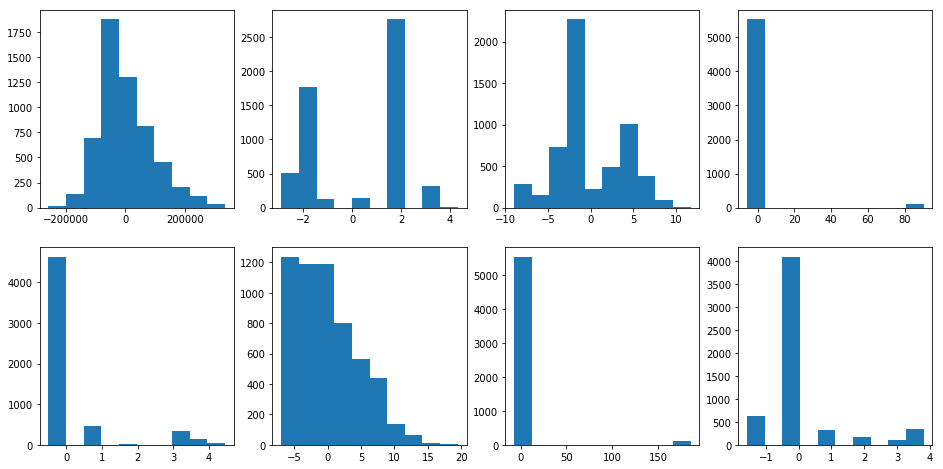

In [32]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(16, 8)

for i in range(2):
    for j in range(4):
        axs[i][j].hist(X_df[pcas[i][j]])

In [36]:
print("support")
transcribe(support_rule_stats)

print("overlap -clr")

transcribe(clr_rule_stats)

support
12.427
BirthCount_index > -5 and
Residence_index <= 46 and
Main wall material is not "Stone with mud" and
Sons at home > 2 and
Current contraceptive method is not "Female sterilization"


79.058
BirthCount_index > -5 and
Sons at home <= 2


overlap -clr
35.422
MaritalStatus_index > -1 and
Wealth_Assets_index > -36570 and
Ethnicity is not "Boran" and
Ethnicity is not "Maasai" and
Sons who have died <= 2 and
Index last child prior to maternity-health (calendar) > 0 and
Visited by fieldworker in last 12 months is not "Yes" and
Cohabitation duration (grouped) is not "0-4"


11.984
MaritalStatus_index > -1 and
Ethnicity is not "Maasai" and
Current contraceptive method is  "Implants/Norplant" and
Cohabitation duration (grouped) is not "0-4"


27.385
Ethnicity is not "Maasai" and
Age of household head <= 46 and
Current contraceptive method is  "Injections" and
Visited by fieldworker in last 12 months is not "Yes"


29.014
MaritalStatus_index > -1 and
Sons at home <= 4 and
Current cont

In [37]:
# support = X_df[(~X_df["v116_97"].astype(bool) & ~X_df["v122_7"].astype(bool) & (X_df["v201"] > 0.500))| (X_df["v116_97"].astype(bool) & X_df["v122_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] <= 2.500) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))]

# propensity = X_df[((X_df["v191"] <= 290545.000) & (X_df["v191"] > -188796.000))]

# print(len(support)/len(X_df))
# print(len(propensity)/len(X_df))

# X_overlap = pd.merge(support, propensity, how='inner')
# print(len(X_overlap) / len(X_df))

In [ ]:
import seaborn as sns
x = []
y = []
v = []
for r in results:
    x.append(r['lambda0'])
    y.append(r['lambda1'])
    
    v.append(r['auc'])

plot = sns.scatterplot(x=[str(X) for X in x], y=[str(Y) for Y in y], hue=v, hue_order= [0.5,0.6,0.7,0.8,0.9,1.0])
leg = plot.get_legend()
for t in leg.texts:
    t.set_text(float(t.get_text()[:4]))

plt.xlabel('λ0')
plt.ylabel('λ1')

In [ ]:
# LAMBDA_0 = np.logspace(-6, 0, 10)
# LAMBDA_1 = np.logspace(-6, 0, 10)

# for lambda_0 in LAMBDA_0:
    
#     for lambda_1 in LAMBDA_1:
